In [ ]:
%load_ext autoreload
%autoreload 2

# Simple Example: UQ Study with OpenUQFOAM

This notebook demonstrates basic usage of the OpenUQFOAM framework.

In [ ]:
import sys
import os
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Import OpenUQFOAM modules
from uq_runner import run_simulation, generate_samples, run_uq_study
from openfoam_tools import load_config, parse_openfoam_case, read_uq_experiment

from uqpylab import sessions
import dotenv
dotenv.load_dotenv()
myToken = os.getenv("UQPYLAB_TOKEN")            # pass your uqpylab token here
UQCloud_instance = 'https://uqcloud.ethz.ch'    # The UQCloud instance to use

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
mySession = sessions.cloud(host=UQCloud_instance, token=myToken) # Start the session
uq = mySession.cli # (Optional) Get a convenient handle to the command line interface
mySession.reset() # Reset the session
uq.rng(100,'twister'); # Set the random seed for reproducibility

 uqpylab.sessions :: INFO     :: This is UQ[py]Lab, version 1.0, running on https://uqcloud.ethz.ch. 
                                 UQ[py]Lab is free software, published under the open source BSD 3-clause license.
                                 To request special permissions, please contact:
                                  - Stefano Marelli (marelli@ibk.baug.ethz.ch).
                                 A new session (3ab7fbcd89c34aa7aada27f47b6e3f2b) started.
 uqpylab.sessions :: INFO     :: Reset successful.


## 1. Single realization

In [4]:
exp_config = {
    'solver': 'Allrun',
    'experiment': {
        'name': 'multiParameters',
        'base_case_dir': "../templates/cavity"
    },
}

In this case, all the randomized parameters are in the same file. However, it is completely possible to pass parameters in different files accros the template folder

In [5]:
run_simulation(params={
    'constant__momentumTransport__Cmu': 0.09,
    'constant__momentumTransport__C1': 1.44,
    'constant__momentumTransport__C2': 1.92,
    'constant__momentumTransport__sigmaK': 1.0,
    'constant__momentumTransport__sigmaEps': 1.3
}, exp_config=exp_config)

In [6]:
# read the OpenFOAM 
data_single = parse_openfoam_case(
    case_dir=f"../experiments/{exp_config['experiment']['name']}",
    variables=["U", "p", "k"]
)
data_single

['0', '0.5', '1', '1.5', '10', '2', '2.5', '3', '3.5', '4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5', '9', '9.5']


<xarray.Dataset> Size: 346kB
Dimensions:  (time: 21, cell: 400, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0
    x        (cell) float64 3kB 0.0025 0.0075 0.0125 ... 0.0875 0.0925 0.0975
    y        (cell) float64 3kB 0.0025 0.0025 0.0025 ... 0.0975 0.0975 0.0975
    z        (cell) float64 3kB 0.005 0.005 0.005 0.005 ... 0.005 0.005 0.005
Dimensions without coordinates: cell, component
Data variables:
    U        (time, cell, component) float64 202kB 0.0 0.0 0.0 ... -0.06503 0.0
    p        (time, cell) float64 67kB 0.0 0.0 0.0 ... 0.00569 0.01775 0.0357
    k        (time, cell) float64 67kB 0.00375 0.00375 ... 0.0005232 0.0004677

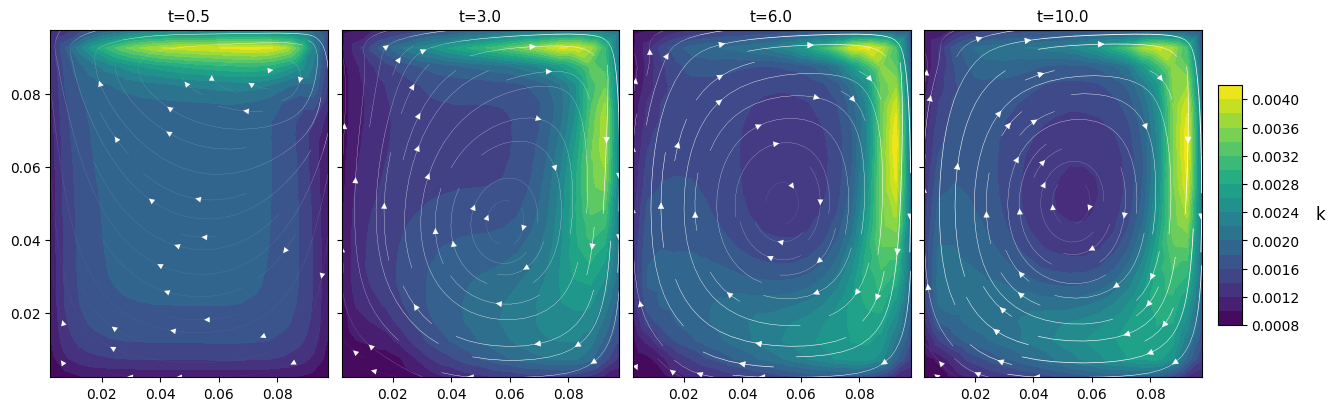

In [7]:
times = [0.5, 3, 6, 10]
time_indices = [data_single.time.get_index('time').get_indexer([t], method='nearest')[0] for t in times]

fig, axs = plt.subplots(1, len(times), figsize=(12, 4), sharex=True, sharey=True, constrained_layout=True)

for i, tidx in enumerate(time_indices):
    temp = data_single['k'].isel(time=tidx).values
    
    x = data_single.x.values
    y = data_single.y.values
    
    cs = axs[i].tricontourf(x, y, temp, cmap='viridis', levels=20)
    
    vel = data_single['U'].isel(time=tidx).values
    ux_orig = vel[:, 0]
    uy_orig = vel[:, 1]

    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)

    uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
    uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')
    
    ut_grid = np.sqrt(uxi**2 + uyi**2)

    lw = ut_grid * 3
    axs[i].streamplot(xi, yi, uxi, uyi, density=0.6, color='white', linewidth=lw, arrowsize=1)
    
    axs[i].set_xlim([x.min(), x.max()])
    axs[i].set_ylim([y.min(), y.max()])

    axs[i].set_title(f't={times[i]:.1f}', fontsize=11)

cs = axs[0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('k', rotation=0, labelpad=15, fontsize=12)

plt.show()

In [ ]:
def compute_qois(ds, time_index=-1, grid_res=200):
    """
    Compute QoIs for lid-driven cavity:
        1. Vortex strength: integral of |vorticity| over the domain
        2. Total kinetic energy
    """
    u = ds['U'].isel(time=time_index).values
    x = ds.x.values
    y = ds.y.values

    ux, uy = u[:, 0], u[:, 1]
    
    xi = np.linspace(x.min(), x.max(), grid_res)
    yi = np.linspace(y.min(), y.max(), grid_res)
    X, Y = np.meshgrid(xi, yi)

    UX = griddata((x, y), ux, (X, Y), method='cubic')
    UY = griddata((x, y), uy, (X, Y), method='cubic')

    
    # --- 1) Vorticity (z-component in 2D)
    dUY_dx, dUY_dy = np.gradient(UY, xi, yi, edge_order=2)
    dUX_dx, dUX_dy = np.gradient(UX, xi, yi, edge_order=2)
    vorticity = dUY_dx - dUX_dy
    vortex_strength = np.trapz(np.trapz(np.abs(vorticity), xi), yi)

    # --- 2) Total kinetic energy
    kinetic_energy_density = 0.5 * (UX**2 + UY**2)
    kinetic_energy = np.trapz(np.trapz(kinetic_energy_density, xi), yi)

    return {
        'vortex_strength': vortex_strength,
        'kinetic_energy': kinetic_energy,
    }

qois = compute_qois(data_single)

print("Vortex strength QoI:", qois['vortex_strength'])
print("Total kinetic energy QoI:", qois['kinetic_energy'])

Vortex strength QoI: 0.028980553675580053
Total kinetic energy QoI: 5.4615387733706813e-05
Vortex center QoI: (0.09224874371859297, 0.0975)


## 2. Load configuration

In [9]:
config = load_config("config_03.yml")
param_ranges = config['parameter_ranges']

print("Parameter ranges:")
for param, range_vals in param_ranges.items():
    print(f"  {param}: {range_vals}")

Parameter ranges:
  constant__momentumTransport__Cmu: [0.07, 0.11]
  constant__momentumTransport__C1: [1.3, 1.6]
  constant__momentumTransport__C2: [1.8, 2.1]
  constant__momentumTransport__sigmaK: [0.85, 1.2]
  constant__momentumTransport__sigmaEps: [1.1, 1.5]


In [31]:
nsamples = 240

ModelOpts = {
    'Type': 'Model',
    'ModelFun': 'uq_runner.uq_simulation',
    "Parameters" : config
}

InputOpts = { "Marginals": [
        {
            "Name": k.split('__')[-1],
            "Type": "Uniform",
            "Parameters": [lb, ub]
        } for k, (lb, ub) in config['parameter_ranges'].items()
    ]
}

myInput = uq.createInput(InputOpts)
myModel = uq.createModel(ModelOpts)

X_ED = uq.getSample(myInput, nsamples, 'LHS')
X_ED

array([[0.08006359, 1.49270589, 1.80126152, 1.09561052, 1.47666585],
       [0.0810784 , 1.37748752, 2.05773623, 1.1315888 , 1.44487138],
       [0.09473556, 1.33350119, 1.88591953, 0.86164299, 1.4589606 ],
       ...,
       [0.09602004, 1.43829771, 1.93193729, 0.87488815, 1.23919094],
       [0.10158901, 1.34371503, 1.97958302, 1.1542504 , 1.42263356],
       [0.10970638, 1.33043396, 1.83249559, 1.1768378 , 1.43724299]])

## 3. Simulate sampled inputs

In [32]:
uq.evalModel(myModel, X_ED, kwargs={'verbose': True})

Running simulations:   0%|          | 0/240 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 240/240 [53:47<00:00, 13.45s/it] 

Simulation executed successfully. Files saved in 'experiments/myFirstSurrogate' folder


array([[None]], dtype=object)

In [33]:
ds = read_uq_experiment(
    case_dir=f"../experiments/{config['experiment']['name']}",
    variables=["U", "k", "p"],
    n_samples=nsamples,
    nthreads=10
)
ds

Processing cases: 100%|██████████| 240/240 [00:29<00:00,  8.05case/s]


<xarray.Dataset> Size: 81MB
Dimensions:  (sample: 240, time: 21, cell: 400, component: 3)
Coordinates:
  * time     (time) float64 168B 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0
    x        (cell) float64 3kB 0.0025 0.0075 0.0125 ... 0.0875 0.0925 0.0975
    y        (cell) float64 3kB 0.0025 0.0025 0.0025 ... 0.0975 0.0975 0.0975
    z        (cell) float64 3kB 0.005 0.005 0.005 0.005 ... 0.005 0.005 0.005
  * sample   (sample) int64 2kB 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
Dimensions without coordinates: cell, component
Data variables:
    U        (sample, time, cell, component) float64 48MB 0.0 0.0 ... -0.332 0.0
    k        (sample, time, cell) float64 16MB 0.00375 0.00375 ... 0.00977
    p        (sample, time, cell) float64 16MB 0.0 0.0 0.0 ... -0.06332 -0.08918

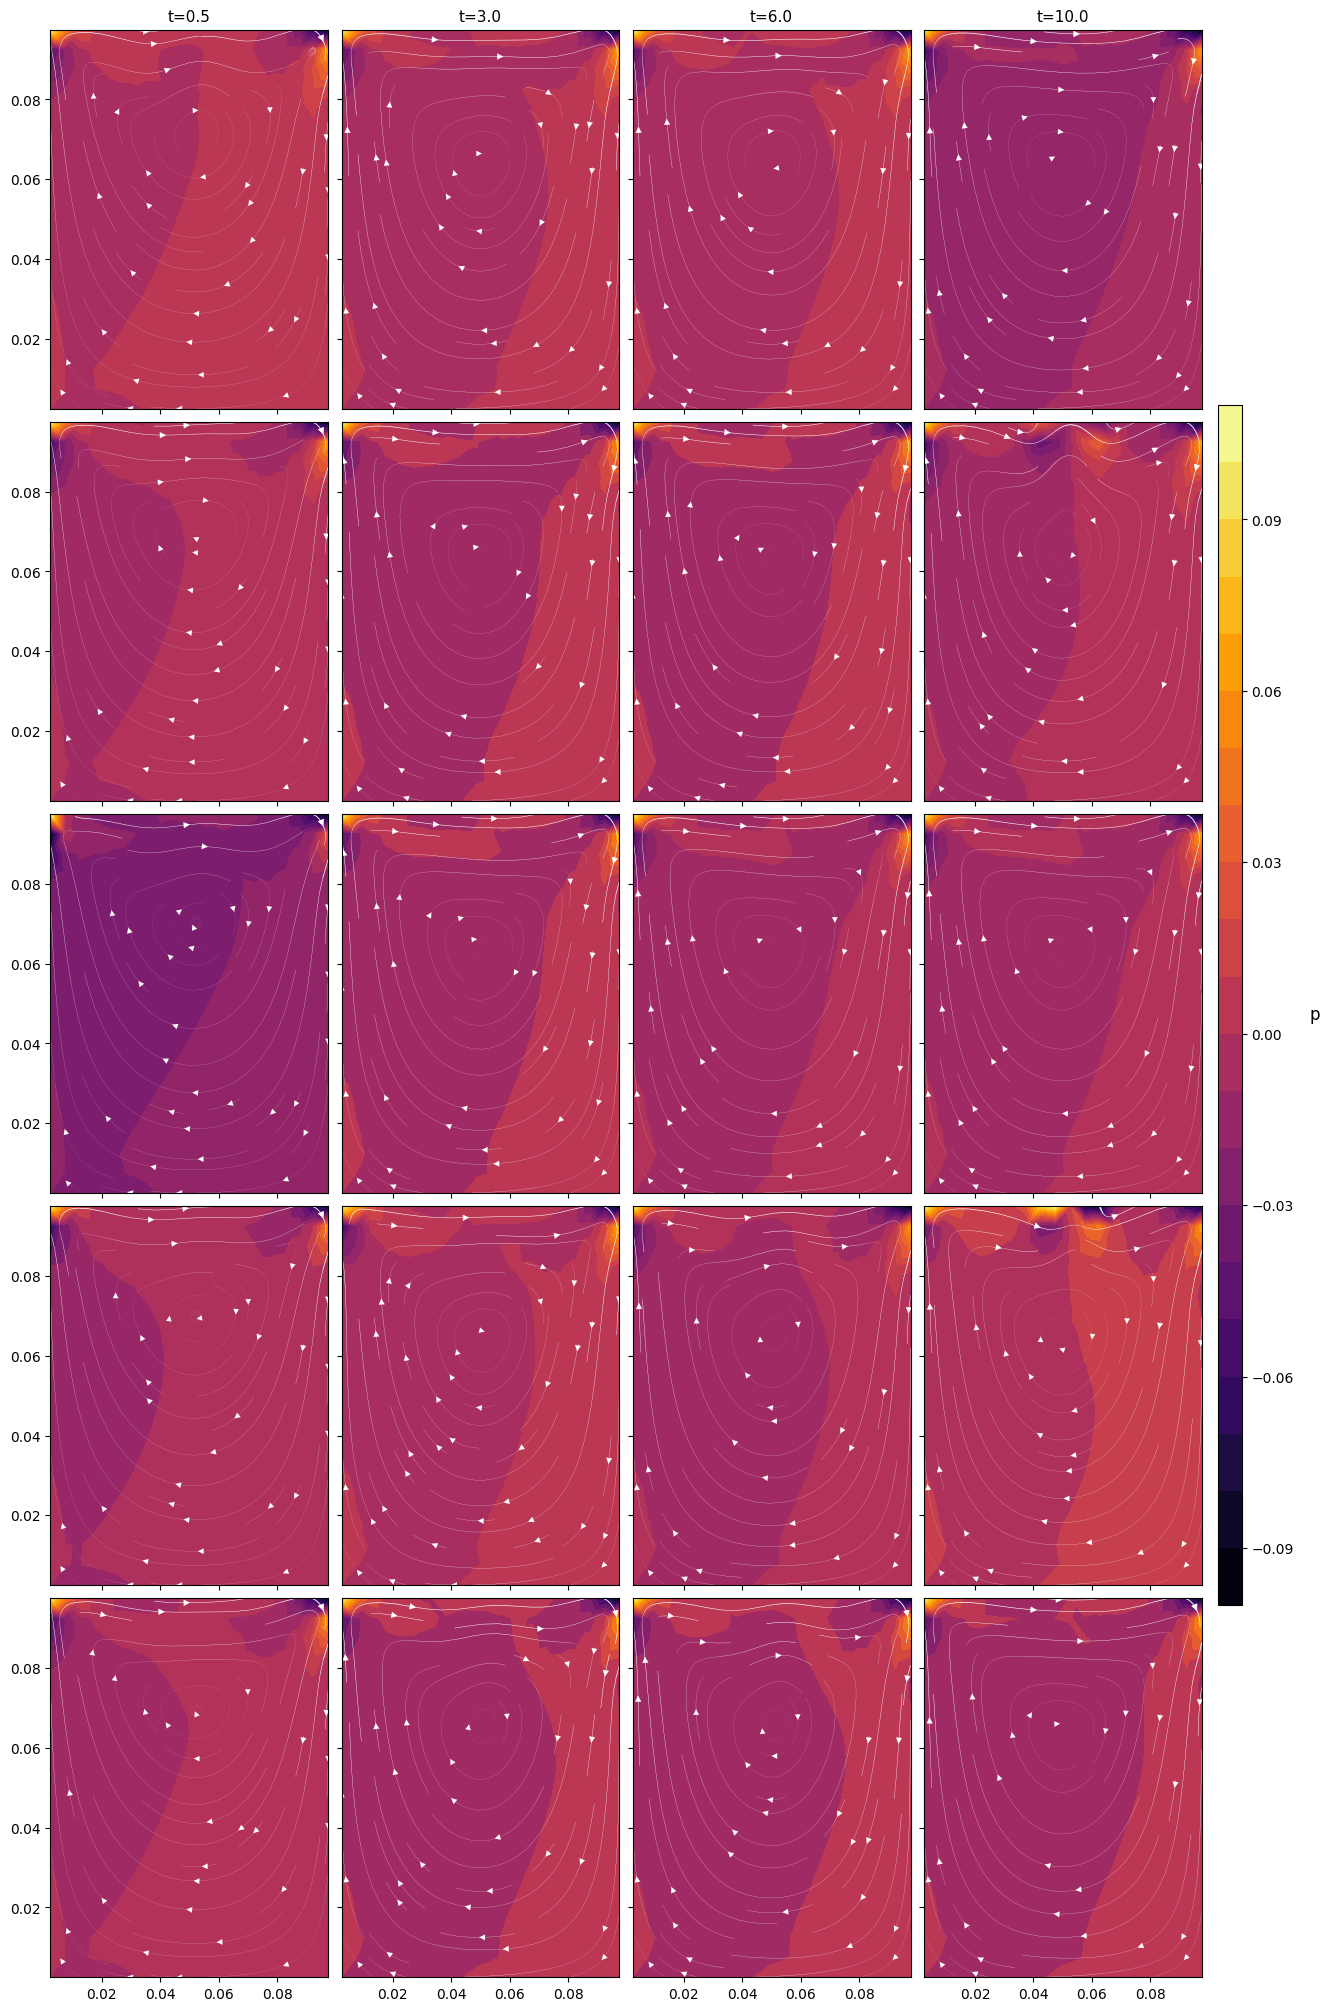

In [37]:
fig, axs = plt.subplots(5, len(times), figsize=(12, 20), sharex=True, sharey=True, constrained_layout=True)

for j, isample in enumerate(np.random.choice(range(nsamples), size=5, replace=False)):
    ds_sample = ds.isel(sample=isample)
    for i, tidx in enumerate(time_indices):
        temp = ds_sample['p'].isel(time=tidx).values
        
        x = ds_sample.x.values
        y = ds_sample.y.values
        
        cs = axs[j, i].tricontourf(x, y, temp, cmap='inferno', levels=20)
        
        vel = ds_sample['U'].isel(time=tidx).values
        ux_orig = vel[:, 0]
        uy_orig = vel[:, 1]

        xi = np.linspace(x.min(), x.max(), 100)
        yi = np.linspace(y.min(), y.max(), 100)
        X, Y = np.meshgrid(xi, yi)

        uxi = griddata((x, y), ux_orig, (X, Y), method='cubic')
        uyi = griddata((x, y), uy_orig, (X, Y), method='cubic')
        
        ut_grid = np.sqrt(uxi**2 + uyi**2)

        lw = ut_grid * 5
        axs[j, i].streamplot(xi, yi, uxi, uyi, density=0.6, color='white', linewidth=lw, arrowsize=1)

        axs[j, i].set_xlim([x.min(), x.max()])
        axs[j, i].set_ylim([y.min(), y.max()])

for i in range(len(times)):
    axs[0, i].set_title(f't={times[i]:.1f}', fontsize=11)

cs = axs[0,0].collections[0]
cbar_ax = fig.add_axes([1.01, 0.2, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax)
cbar.set_label('p', rotation=0, labelpad=15, fontsize=12)

plt.show()

#### Extract QoIs

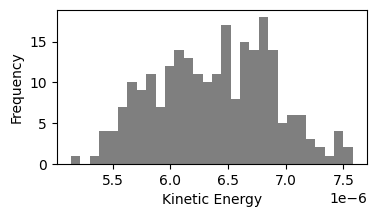

In [66]:
qois_samples = []
for i in range(nsamples):
    ds_sample = ds.isel(sample=i)
    qois = compute_qois(ds_sample)
    qois_samples.append(qois)

plt.figure(figsize=(4, 2))
plt.hist([q['kinetic_energy'] for q in qois_samples],
          bins=30, color='k', linewidth=1, alpha=0.5)
plt.xlabel('Kinetic Energy')
plt.ylabel('Frequency')
plt.show()

In [39]:
Y_ED = [ q['kinetic_energy'] for q in qois_samples ]

In [40]:
MetaOpts = {
    'Type': 'Metamodel',
    'MetaType': 'PCE',
        'ExpDesign': {
        'X': X_ED.tolist(),
        'Y': Y_ED
    },
    'Degree': [1, 2, 3, 4] # Range of the degrees to be compared by the adaptive algorithm
    # The degree with the lowest Leave-One-Out cross-validation (LOO) error estimator is chosen as the final metamodel.
}

myPCE = uq.createModel(MetaOpts)
uq.print(myPCE)


%------------ Polynomial chaos output ------------%
   Number of input variables:    5
   Maximal degree:               4
   q-norm:                       1.00
   Size of full basis:           126
   Size of sparse basis:         8
   Full model evaluations:       240
   Leave-one-out error:          1.3593803e-01
   Modified leave-one-out error: 1.4535922e-01
   Mean value:                   0.0000
   Standard deviation:           0.0000
   Coef. of variation:             7.627%
%--------------------------------------------------%



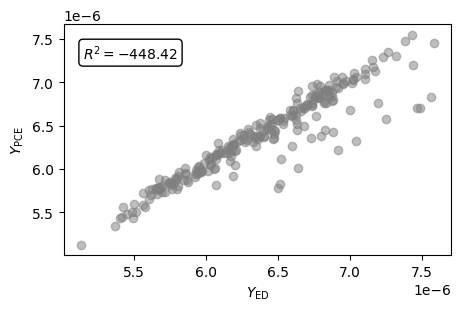

In [67]:
Y_PCE = uq.evalModel(myPCE, X_ED)

plt.figure(figsize=(5,3))
plt.plot(Y_ED, Y_PCE, 'o', color='tab:gray', alpha=0.5)

# calculate r2
def r2_score(y_true, y_pred):
    """Calculate the R^2 score."""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)
# from sklearn.metrics import r2_score
acc = r2_score(Y_ED, Y_PCE)

plt.annotate(f'$R^2 = {acc:.2f}$', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.xlabel(r'$Y_\mathrm{ED}$')
plt.ylabel(r'$Y_\mathrm{PCE}$')
plt.show()

In [50]:
SobolOpts = {
    "Type": "Sensitivity",
    "Method": "Sobol",
    "Sobol": {
        "SampleSize": 1e5
    }
}

mySobolAnalysis = uq.createAnalysis(SobolOpts)

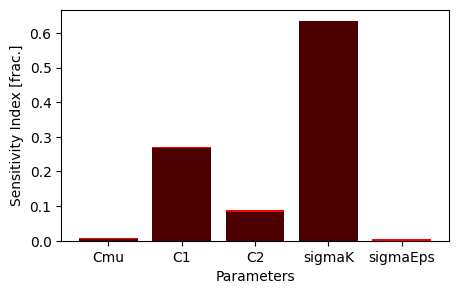

In [63]:
SobolResults = mySobolAnalysis['Results']
params = SobolResults['VariableNames']

plt.figure(figsize=(5, 3))
plt.bar(params, SobolResults['Total'], color='red')
plt.bar(params, SobolResults['FirstOrder'], color='black', alpha=0.7)

plt.ylabel('Sensitivity Index [frac.]')
plt.xlabel('Parameters')

plt.show()